# **Twitter US Airline Sentiment with Keras & TensorFlow**

**Dataset:** Twitter US Airline Sentiment - https://www.kaggle.com/crowdflower/twitter-airline-sentiment/data#

Originally came from Crowdflower's Data for Everyone library

**Code:** Keras code example "Using pre-trained word embeddings" - https://keras.io/examples/nlp/pretrained_word_embeddings/

### Classify images within 10 categories ###

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.1.0


## Get the data ##

### Dataset attributes:###

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

In [3]:
import os

TWITTER_AIRLINE_PATH = "dataset"

def load_twitter_airline_data(twitter_airline_path=TWITTER_AIRLINE_PATH):
    csv_path = os.path.join(twitter_airline_path, "tweets.csv")
    return pd.read_csv(csv_path)

In [4]:
twitter_airline = load_twitter_airline_data()
twitter_airline.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
twitter_airline["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

# Data preparation

In [6]:
num_classes = 3

In [7]:
twitter_airline_prep = twitter_airline.replace({'positive':'0', 'neutral':'1', 'negative':'2'})

In [8]:
twitter_airline_prep = twitter_airline_prep.filter(["airline_sentiment", "text"])

In [9]:
X_train = twitter_airline_prep.drop("airline_sentiment", axis=1)
y_train = twitter_airline_prep["airline_sentiment"].copy()

In [10]:
y_train = y_train.apply(pd.to_numeric) #Change the type to integer

In [11]:
X_test = twitter_airline_prep.drop("airline_sentiment", axis=1)
y_test = twitter_airline_prep["airline_sentiment"].copy()

In [12]:
y_test = y_test.apply(pd.to_numeric) #Change the type to integer

Shuffle the training data:

In [13]:
np.random.seed(42)

shuffle_index = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train.iloc[shuffle_index], y_train.iloc[shuffle_index]

## Model

Consider the top 20,000 words, and truncate or pad sequences to be 200 tokens long:

In [14]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_features = 20000
embedding_dim = 128
sequence_length = 200

vectorizer = TextVectorization(
    #standardize=custom_standardization,    Default is 'lower_and_strip_punctuation' (lowercase and remove punctuation)
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

vectorizer.adapt(X_train.to_numpy())

TextVectorization transforms strings into a list of token integer indices, to index the vocabulary found in the dataset

In [15]:
vectorizer.get_vocabulary()[:5] 

[b'to', b'the', b'i', b'a', b'united']

In [16]:
output = vectorizer(np.array([["This airline is really good"]]))
output.numpy()[0, :5]

array([ 30, 102,  15, 133, 134], dtype=int64)

In [17]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(2, len(voc))))

In [18]:
test = [b"this", b"airline", b"is", b"really", b"good"]
[word_index[w] for w in test]

[30, 102, 15, 133, 134]

Use the pre-trained word vectors from https://nlp.stanford.edu/projects/glove/.<br>Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation

6B tokens, 400K vocabulary, uncased and 50, 100, 200 and 300 dimension vectors. Use the 100 dimensions vectors:

In [19]:
import io  #use io package to be able to specify the encoding when opening a file

glove_path = os.path.join(TWITTER_AIRLINE_PATH, "glove.6B.100d.txt")

embeddings_index = {}
with io.open(glove_path, mode="r", encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


The embedding matrix is a NumPy matrix where entry at index i is the pre-trained vector for the word of index i in the vectorizer's vocabulary.

In [20]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word.decode("utf-8"))
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10113 words (7017 misses)


### Visualize the dataset vocabulary vs. GloVe vocabulary

In [21]:
embedding_matrix_full = np.zeros((len(embeddings_index), embedding_dim))
i = 0
for embedding_vector in embeddings_index.values():
    embedding_matrix_full[i] = embedding_vector
    i += 1

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X2D = pca.fit_transform(embedding_matrix)

In [23]:
pca.explained_variance_ratio_

array([0.1317866 , 0.04222822])

In [24]:
X2D_full = pca.fit_transform(embedding_matrix_full)

In [25]:
pca.explained_variance_ratio_

array([0.06054711, 0.03435695])

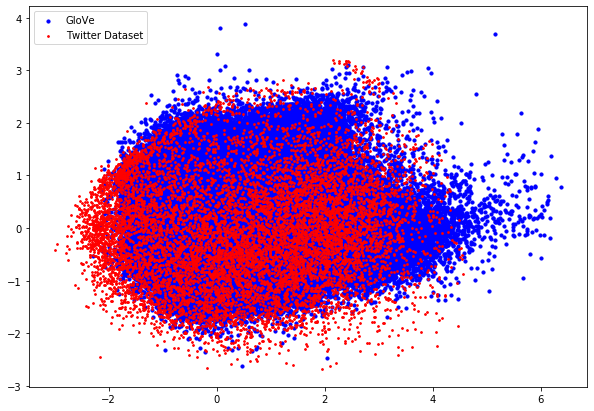

In [26]:
plt.figure(figsize=(10, 7))

plt.scatter(X2D_full[:, 0], X2D_full[:, 1], color='blue', s=10, label="GloVe")
plt.scatter(X2D[:, 0], X2D[:, 1], color='red', s=3, label="Twitter Dataset")
plt.legend(loc="upper left")

plt.show()

Create a Keras layer with the embedding matrix:

In [27]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [28]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         1713400   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         82048 

The training input is vectorized:

In [29]:
X_train_prep = vectorizer(X_train.to_numpy()).numpy()

y_train_prep = np.array(y_train)

In [30]:
batch_size = 128
epochs = 20

model.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"]
)
history = model.fit(X_train_prep, y_train_prep, batch_size=batch_size, epochs=epochs, validation_split = 0.1)

Train on 13176 samples, validate on 1464 samples
Epoch 1/20
13176/13176 [==============================] - 18s 1ms/sample - loss: 0.8028 - accuracy: 0.6655 - val_loss: 0.6575 - val_accuracy: 0.7193
Epoch 2/20
13176/13176 [==============================] - 17s 1ms/sample - loss: 0.6228 - accuracy: 0.7577 - val_loss: 0.7143 - val_accuracy: 0.7206
Epoch 3/20
13176/13176 [==============================] - 17s 1ms/sample - loss: 0.5395 - accuracy: 0.7895 - val_loss: 0.5517 - val_accuracy: 0.7725
Epoch 4/20
13176/13176 [==============================] - 17s 1ms/sample - loss: 0.4810 - accuracy: 0.8163 - val_loss: 0.6436 - val_accuracy: 0.7643
Epoch 5/20
13176/13176 [==============================] - 17s 1ms/sample - loss: 0.4216 - accuracy: 0.8432 - val_loss: 0.5353 - val_accuracy: 0.7862
Epoch 6/20
13176/13176 [==============================] - 17s 1ms/sample - loss: 0.3574 - accuracy: 0.8698 - val_loss: 0.6130 - val_accuracy: 0.7719
Epoch 7/20
13176/13176 [==============================] -

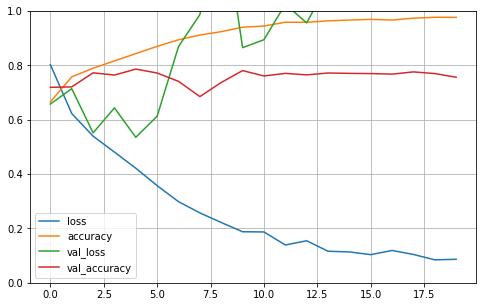

In [31]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [32]:
X_test_prep = vectorizer(X_test.to_numpy()).numpy()

y_test_prep = np.array(y_test)

In [33]:
score = model.evaluate(X_test_prep, y_test_prep, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.147441007135324
Test accuracy: 0.96530056


In [34]:
def predict_sentiment(text = "OK"):
    
    sentiment_mapping = ['positive', 'neutral', 'negative']

    string_input = keras.Input(shape=(1,), dtype="string")
    x = vectorizer(string_input)
    preds = model(x)
    end_to_end_model = keras.Model(string_input, preds)

    probabilities = end_to_end_model.predict(
        [[text]]
    )

    return sentiment_mapping[np.argmax(probabilities[0])]

In [35]:
print(predict_sentiment("The flight was not so great, due to the long delay."))

negative


In [36]:
print(predict_sentiment("The flight was OK."))

neutral


In [37]:
print(predict_sentiment("What a nice experience all along!"))

positive
